In [ ]:
#Function and modules for the supervised regression models


from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor # type: ignore
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
# No additional code needed


In [ ]:
#Function and modules from data analysis and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,f_regression

In [ ]:
#Functions and modules for deep learning models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

In [ ]:
#Functions and modules for the time series models
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf
from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf
import requests

#Another way of accessing financial data using the Alpha Vantage API
# api_key = "8ART2Y2DWLVOVTB6"

# def fetch_stock_data(api_key, function, symbol, interval=None, adjusted=True, extended_hours=True,
#                      month=None, outputsize='compact', datatype='json'):
#     base_url = "https://www.alphavantage.co/query"
#     params = {
#         "function": function,
#         "symbol": symbol,
#         "apikey": api_key,
#         "outputsize": outputsize,
#         "datatype": datatype
#     }
    
#     if function == "TIME_SERIES_INTRADAY":
#         params.update({
#             "interval": interval,
#             "adjusted": str(adjusted).lower(),
#             "extended_hours": str(extended_hours).lower()
#         })
#         if month:
#             params["month"] = month
    
#     try:
#         response = requests.get(base_url, params=params)
#         response.raise_for_status()
        
#         if datatype == "json":
#             data = response.json()
            
#             # Handle FX data
#             if function == "FX_DAILY":
#                 time_series_key = "Time Series FX (Daily)"
#             else:
#                 time_series_key = next((k for k in data.keys() if "Time Series (Daily)" in k), None)
            
#             if time_series_key and time_series_key in data:
#                 df = pd.DataFrame.from_dict(data[time_series_key], orient="index")
#                 # Convert all numeric columns from strings to float
#                 for col in df.columns:
#                     df[col] = pd.to_numeric(df[col], errors='coerce')
#                 return df
#             else:
#                 print(f"Warning: No time series data found for {symbol}")
#                 return None
                
#         elif datatype == "csv":
#             from io import StringIO
#             return pd.read_csv(StringIO(response.text))
            
#     except requests.exceptions.RequestException as e:
#         print(f"Error fetching data for {symbol}: {str(e)}")
#         return None
#     except ValueError as e:
#         print(f"Error processing data for {symbol}: {str(e)}")
#         return None

# Stock tickers
stk_tickers = ['MSFT', 'IBM', 'GOOGL']

# Load stock data using yfinance

stk_data = yf.download(stk_tickers, start="2021-01-01", end="2023-12-31", group_by="ticker")
stk_data = stk_data.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)
stk_data = stk_data.pivot(columns="Ticker", values="Adj Close")

# Fetch currency data using yfinance

currency_tickers = ["JPYUSD=X", "GBPUSD=X"]
ccy_data = yf.download(currency_tickers, start="2021-01-01", end="2023-12-31")['Adj Close']
ccy_data.columns = ['JPY/USD', 'GBP/USD']  # Rename columns for clarity

# Fetch index data using yfinance

index_tickers = ['^GSPC', '^DJI', '^VIX']  # S&P 500, Dow Jones, VIX
idx_data = yf.download(index_tickers, start="2021-01-01", end="2023-12-31")['Adj Close']
idx_data.columns = ['S&P 500', 'Dow Jones', 'VIX']  # Rename columns for clarity

# Define return period
return_period = 5

# Define dependent variable Y
Y = np.log(stk_data['MSFT']).diff(return_period).shift(-return_period)
Y.name = 'MSFT_pred'

# Define feature variables X
X_components = []

# Add stock data features
X1 = np.log(stk_data[['GOOGL', 'IBM']]).diff(return_period)
X_components.append(X1)

# Add currency features
if not ccy_data.empty:
    X2 = np.log(ccy_data).diff(return_period)
    X_components.append(X2)

# Add index features
if not idx_data.empty:
    X3 = np.log(idx_data).diff(return_period)
    X_components.append(X3)

# Add lagged MSFT data
X4 = pd.concat([
    np.log(stk_data['MSFT']).diff(i) 
    for i in [return_period, return_period*3, return_period*6, return_period*12]
], axis=1)
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']
X_components.append(X4)

# Combine all features
X = pd.concat(X_components, axis=1)

# Create final dataset
dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]


# Set display options for better output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.6f' % x)

# Print sample of final dataset
print("\nFinal Dataset Sample:")
print(dataset.head())


[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  3 of 3 completed


Final Dataset Sample:
            MSFT_pred     GOOGL       IBM   JPY/USD   GBP/USD   S&P 500  \
Date                                                                      
2021-03-31   0.071520  0.014647  0.020010  0.001181 -0.016315  0.017171   
2021-04-08   0.024379  0.087193  0.013861 -0.003083  0.008141  0.015704   
2021-04-15  -0.009019  0.015354 -0.018977  0.002573  0.008759  0.015766   
2021-04-22  -0.018287 -0.014426  0.063557  0.011015  0.007883 -0.006487   
2021-04-29  -0.011070  0.060398  0.020735  0.001785 -0.004304  0.007203   

            Dow Jones       VIX   MSFT_DT  MSFT_3DT  MSFT_6DT  MSFT_12DT  
Date                                                                      
2021-03-31   0.021306 -0.088728  0.001316  0.014311 -0.035131   0.082085  
2021-04-08   0.030803 -0.135005  0.071520  0.066148  0.076708   0.154525  
2021-04-15   0.017720 -0.022674  0.024379  0.097216  0.131343   0.183744  
2021-04-22  -0.008534  0.121464 -0.009019  0.086881  0.101191   0.103879  
2

In [5]:
dataset.head()

,MSFT_pred,GOOGL,IBM,JPY/USD,GBP/USD,S&P 500,Dow Jones,VIX,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
Date,,,,,,,,,,,,
2021-03-31,0.071520,0.014647,0.020010,0.001181,-0.016315,0.017171,0.021306,-0.088728,0.001316,0.014311,-0.035131,0.082085
2021-04-08,0.024379,0.087193,0.013861,-0.003083,0.008141,0.015704,0.030803,-0.135005,0.071520,0.066148,0.076708,0.154525
2021-04-15,-0.009019,0.015354,-0.018977,0.002573,0.008759,0.015766,0.017720,-0.022674,0.024379,0.097216,0.131343,0.183744
2021-04-22,-0.018287,-0.014426,0.063557,0.011015,0.007883,-0.006487,-0.008534,0.121464,-0.009019,0.086881,0.101191,0.103879
2021-04-29,-0.011070,0.060398,0.020735,0.001785,-0.004304,0.007203,0.018329,-0.060591,-0.018287,-0.002926,0.063222,0.055156


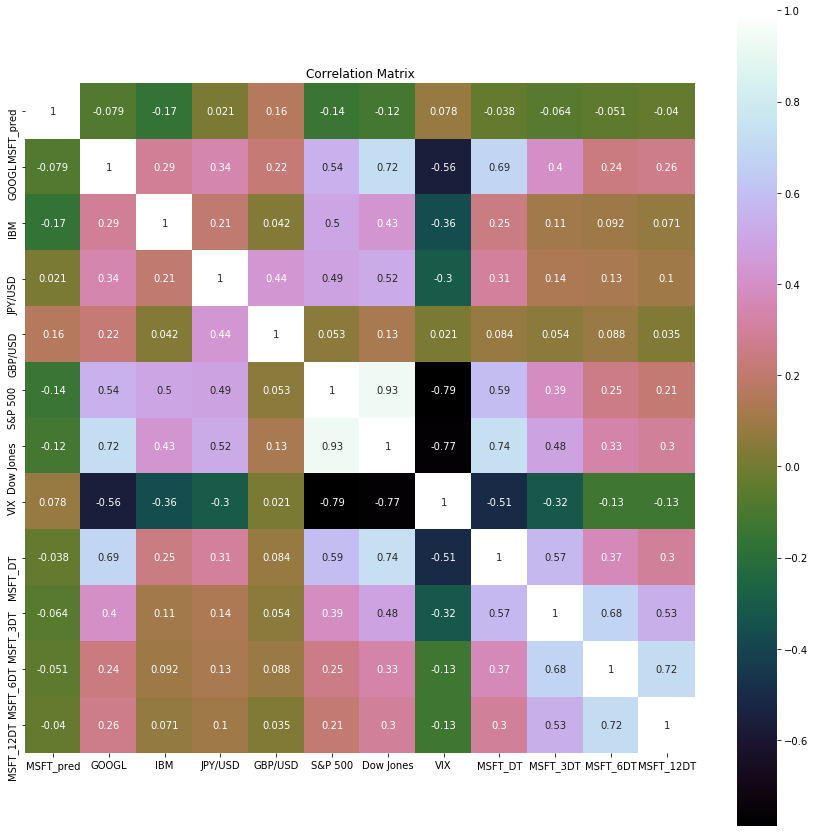

In [6]:
#Data visualization using correlation matrix

from matplotlib import pyplot

correlation = dataset.corr()
pyplot.figure(figsize=(15, 15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation,vmax=1 ,square = True, annot=True, cmap='cubehelix')


<Figure size 1080x1080 with 0 Axes>

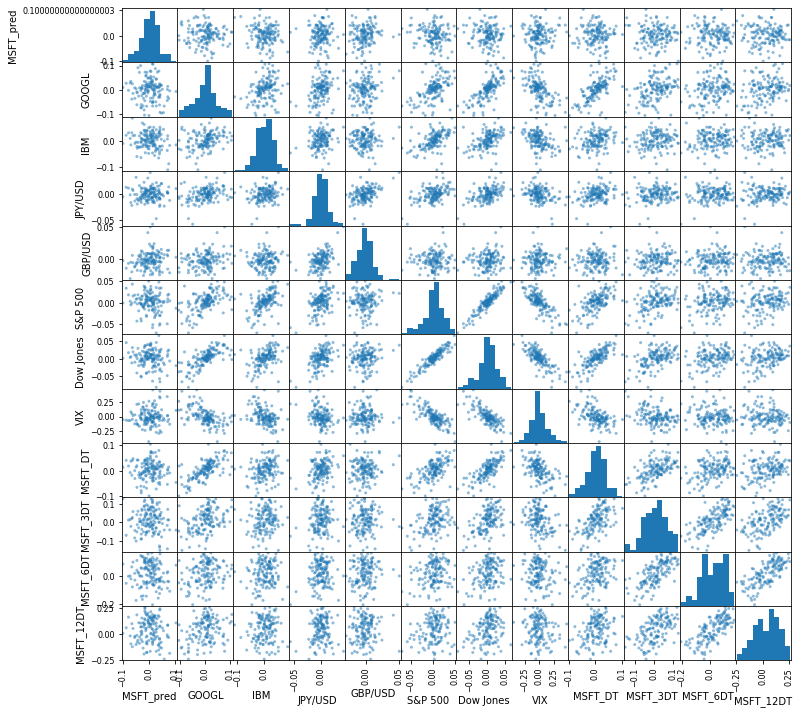

In [7]:
#Data visualization using regression plots
pyplot.figure(figsize=(15, 15))
scatter_matrix(dataset,figsize=(12, 12))
pyplot.show()

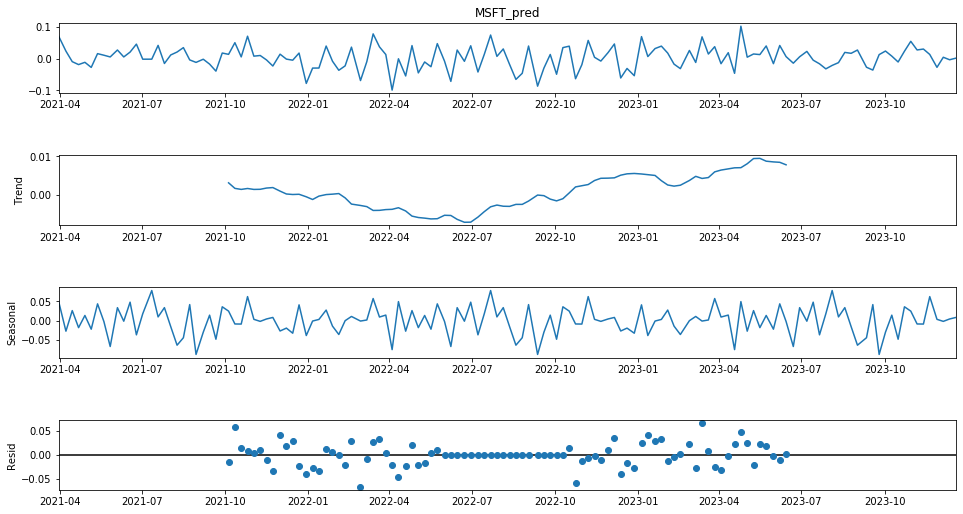

In [8]:
#Time Series Analysis
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

res = sm.tsa.seasonal_decompose(Y,period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

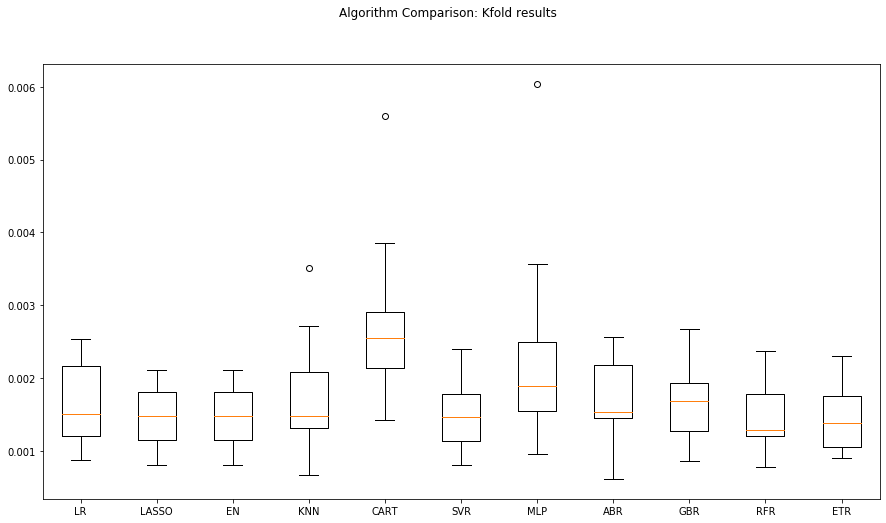

In [27]:
#Function and modules for the supervised regression models


from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor # type: ignore
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
# No additional code needed
#Function and modules from data analysis and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,f_regression


#Evaluation model
# Split data into training and testing sets
validation_size = 0.20
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

# So now doing the 10 fold cross validation to train the model doing this algorithmn using the mean squared metric 
num_folds = 10
scoring = 'neg_mean_squared_error'

#Regression and tree regression algorithma
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

#Neural network algorithmns
models.append(('MLP', MLPRegressor()))

#Essemble algorithmns
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

names = []
kfold_results = []
test_results = []
train_results = []

for name, model in models:
    names.append(name)
    kfold = KFold(n_splits=num_folds,shuffle = True, random_state=123)
    cv_results = -1* cross_val_score(model, X_train,Y_train, cv=kfold,scoring=scoring)
    kfold_results.append(cv_results)
    
    #full model training
    res = model.fit(X_train,Y_train)
    test_result = mean_squared_error(res.predict(X_test),Y_test)
    test_results.append(test_result)
    train_result = mean_squared_error(res.predict(X_train),Y_train)
    train_results.append(train_result)
    

#Looking at the results of Cross Validation

fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

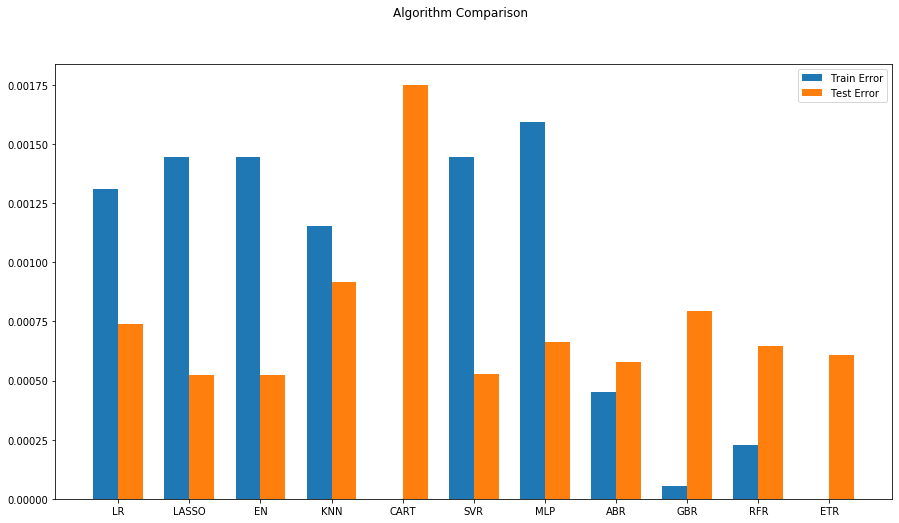

In [29]:
#Looking at the results of Train and Test results
# compare algorithms
fig = pyplot.figure()
ind = np.arange(len(names)) # the x locations for the groups
width = 0.35 # the width of the bars
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results, width=width,
label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width,
label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

In [30]:
#Time Series models
# ARIMA model
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

X_train_ARIMA = X_train.loc[:,['GOOGL','IBM','S&P 500','Dow Jones','VIX','JPY/USD']]
X_test_ARIMA = X_test.loc[:,['GOOGL','IBM','S&P 500','Dow Jones','VIX','JPY/USD']]

tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len(X)

model_ARIMA = ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[1,0,0])
model_fit = model_ARIMA.fit()

error_Training_ARIMA = mean_squared_error(Y_train,model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end =to_len -1,exog = X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test,predicted)
error_Test_ARIMA


0.0007907760642175997

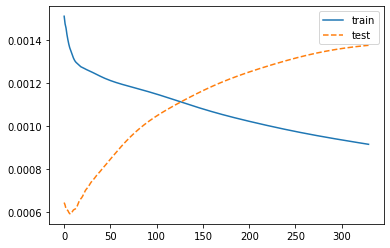

In [31]:
#Functions and modules for deep learning models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor
import numpy as np

#Now creating the LSTM model
#now creating the data set for the LSTM MODEL
seq_len = 2 
Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len,seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len,X.shape[1]))
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]
    
# Create LSTM model

# LSTM Network
def create_LSTMmodel(learn_rate = 0.01, momentum=0):
    # create model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1],X_train_LSTM.shape[2])))
    #More cells can be added if needed
    model.add(Dense(1))
    optimizer = SGD(learning_rate=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer='adam')
    return model

LSTMModel = create_LSTMmodel(learn_rate = 0.01,momentum=0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM,Y_train_LSTM,validation_data=(X_test_LSTM, Y_test_LSTM),epochs=330, batch_size=72, verbose=0, shuffle=False)

pyplot.plot(LSTMModel_fit.history['loss'],
label='train', )
pyplot.plot(LSTMModel_fit.history['val_loss'], '--',label='test',)
pyplot.legend()
pyplot.show()

1/1 [==============================] - 0s 33ms/step


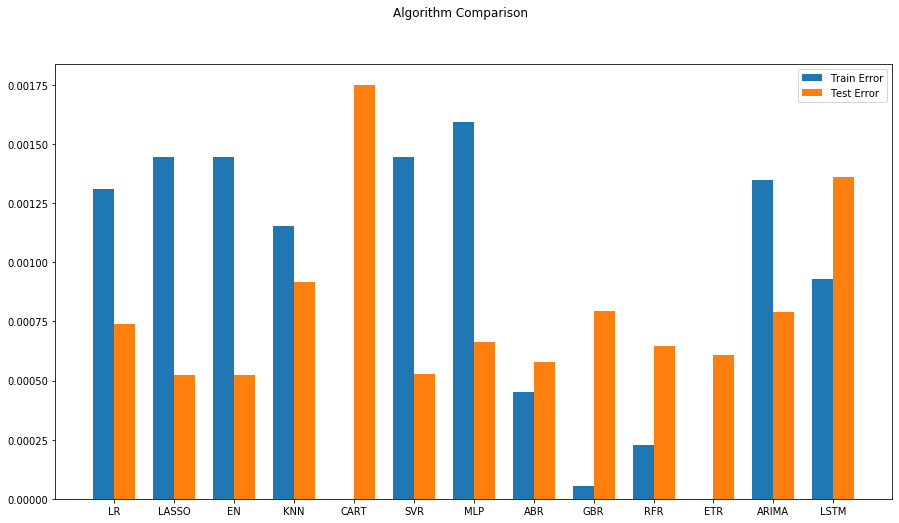

In [32]:
import numpy as np
#Functions and modules for deep learning models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor
import numpy as np

#Now creating the LSTM model
#now creating the data set for the LSTM MODEL
seq_len = 2 
Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len,seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len,X.shape[1]))
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]
    
# Create LSTM model

# LSTM Network
def create_LSTMmodel(learn_rate = 0.01, momentum=0):
    # create model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1],X_train_LSTM.shape[2])))
    #More cells can be added if needed
    model.add(Dense(1))
    optimizer = SGD(learning_rate=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer='adam')
    return model

LSTMModel = create_LSTMmodel(learn_rate = 0.01,momentum=0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM,Y_train_LSTM,validation_data=(X_test_LSTM, Y_test_LSTM),epochs=330, batch_size=72, verbose=0, shuffle=False)


error_Training_LSTM = mean_squared_error(Y_train_LSTM,LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test_LSTM,LSTMModel.predict(X_test_LSTM))

test_results.append(error_Test_ARIMA)
test_results.append(error_Test_LSTM)

train_results.append(error_Training_ARIMA)
train_results.append(error_Training_LSTM)

names.append("ARIMA")
names.append("LSTM")

#Looking at the results of Train and Test results
# compare algorithms
fig = pyplot.figure()
ind = np.arange(len(names)) # the x locations for the groups
width = 0.35 # the width of the bars
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results, width=width,
label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width,
label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()


In [33]:
#Model tuning by using ARIMA model
def evaluate_arima_model(arima_order):

    modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=arima_order)
    model_fit = modelARIMA.fit()
    error = mean_squared_error(Y_train,model_fit.fittedvalues)
    return error

#Grid search for ARIMA model
# evaluate combinations of p, d and q values for an

def evaluate_models(p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
            try:
                mse = evaluate_arima_model(order)
                if mse < best_score:
                    best_score, best_cfg = mse,order
                    print('ARIMA%s MSE=%.7f' %(order,mse))
            except:
                continue
    print('Best ARIMA%s MSE=%.7f' % (best_cfg,best_score))
    
# evaluate parameters
p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values)

ARIMA(0, 0, 1) MSE=0.0013460
ARIMA(1, 0, 1) MSE=0.0013405
ARIMA(2, 0, 1) MSE=0.0013402
Best ARIMA(2, 0, 1) MSE=0.0013402


In [34]:
# prepare model
modelARIMA_tuned=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[2,0,1])
model_fit_tuned = modelARIMA_tuned.fit()
predicted_tuned = model_fit.predict(start = tr_len -1,end = to_len -1, exog = X_test_ARIMA)[1:]
print(mean_squared_error(Y_test,predicted_tuned))


0.0007907760642175997


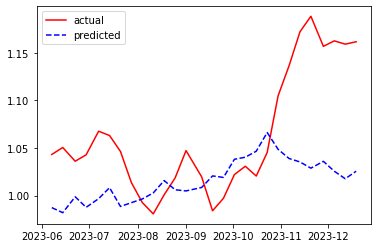

In [35]:
# plotting the actual data versus predicted data
predicted_tuned.index = Y_test.index
pyplot.plot(np.exp(Y_test).cumprod(), 'r',
label='actual',)
# plotting t, a separately
pyplot.plot(np.exp(predicted_tuned).cumprod(), 'b--',
label='predicted')
pyplot.legend()
pyplot.rcParams["figure.figsize"] = (8,5)
pyplot.show()